# IAU Projekt - Fáza 4 - Aktivity na cvičení

## Dataset: Lytvyn Q1, Head CT - hemorrhage data
Peter Brenkus, Tomáš Brček

Percentuálny podiel: 50/50

In [2]:
import os
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, Sequential, regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score

2024-12-06 17:04:03.797655: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
IMAGE_SIZE = 128
BATCH_SIZE = 10

DATASET_DIR = "data/head_ct"
LABELS_FILE = "data/labels.csv"

base_path = "data/head_ct"

# 4.1 EDA and data preprocessing

## A

EDA a data preprocessing pre Vami vybrané charakteristiky z datasetu

In [4]:
labels = pd.read_csv("data/labels.csv", index_col="id")

In [5]:
files = sorted(os.listdir(DATASET_DIR))
normal_imgs = [fn for fn in files if labels.loc[int(fn.split('.')[0]), ' hemorrhage'] == 0]
hemorrhage_imgs = [fn for fn in files if labels.loc[int(fn.split('.')[0]), ' hemorrhage'] == 1]
print(f'Num. normal: {len(normal_imgs)}, num. hemorrhage: {len(hemorrhage_imgs)}')

Num. normal: 100, num. hemorrhage: 100


Môžeme vidieť, že medzi obrázkami máme 100 takých, ktoré sú normálne a 100 takých, na ktorých je krvácanie. Tieto triedy sme si rozdelili do 2 polí.

### Zobrazenie vzorky

In [6]:
normal_selection = np.random.choice(normal_imgs, 5, replace = False)
hemorrhage_selection = np.random.choice(hemorrhage_imgs, 5, replace = False)

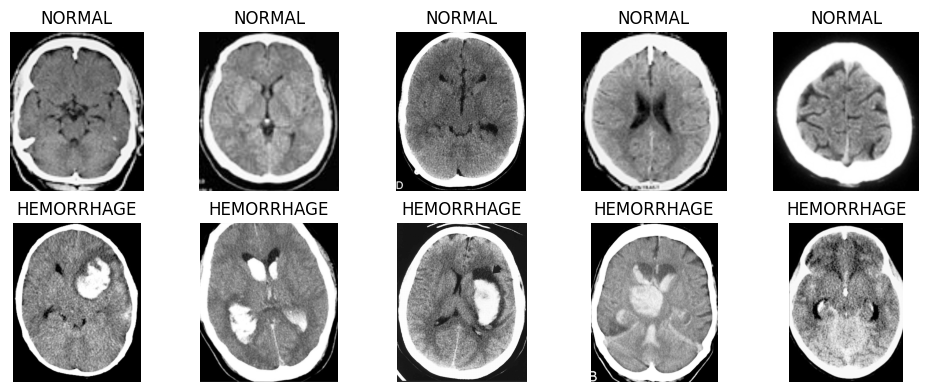

In [7]:
fig = plt.figure(figsize=(12, 12)) 
for i in range(10):
    if i < 5:
        fp = f'data/head_ct/{normal_selection[i]}'
        label = 'NORMAL'
    else:
        fp = f'data/head_ct/{hemorrhage_selection[i-6]}'
        label = 'HEMORRHAGE'
    ax = fig.add_subplot(5, 5, i+1)
    
    fn = image.load_img(fp, color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

Vybrali sme vzorku 5 obrázkov z každej triedy, ktoré sme si vykreslili pre lepšiu predstavu o dátach.

### Zobrazenie priemerného príkladu

In [8]:
def convert_images_to_matrix(directory, filenames, size=(IMAGE_SIZE, IMAGE_SIZE)):
    full_matrix = None
    for filename in filenames:
        file_path = os.path.join(directory, filename)
        loaded_image = image.load_img(file_path, target_size=size, color_mode='grayscale')
        image_array = image.img_to_array(loaded_image).ravel()[np.newaxis, :]
        if full_matrix is None:
            full_matrix = image_array
        else:
            full_matrix = np.vstack((full_matrix, image_array))
    return full_matrix

normal = convert_images_to_matrix('data/head_ct/', normal_imgs)
hemorrhage = convert_images_to_matrix('data/head_ct/', hemorrhage_imgs)

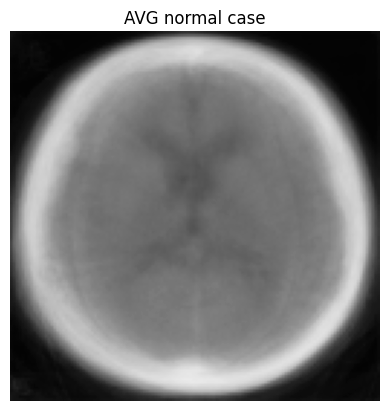

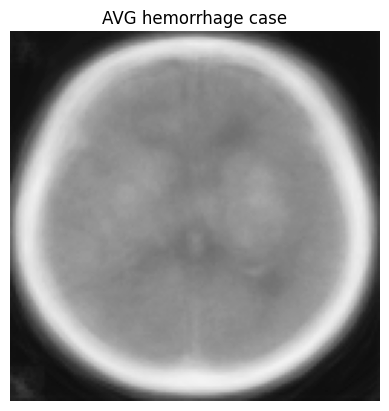

In [9]:
def find_mean_img(full_mat, title, size=(IMAGE_SIZE, IMAGE_SIZE)):
    mean_img = np.mean(full_mat, axis = 0)
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'AVG {title} case')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean_img = find_mean_img(normal, 'normal')
hemorrhage_mean_img = find_mean_img(hemorrhage, 'hemorrhage')

Na obrázkoch vyššie môžeme vidieť priemerné prípady pre normálne snímky, a pre snímky, ktoré obsahujú krvácanie. 

### Príprava datasetu

In [10]:
SEED =42
tf.random.set_seed(SEED)
np.random.seed(SEED)

def load_image_and_label(image_name, label):
    img_path = tf.strings.join([DATASET_DIR, image_name], separator="/")
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])
    return img, label

In [11]:
normal_labels = [0] * len(normal_imgs)
hemorrhage_labels = [1] * len(hemorrhage_imgs)

In [12]:
normal_dataset = tf.data.Dataset.from_tensor_slices((normal_imgs, normal_labels)).map(load_image_and_label)
hemorrhage_dataset = tf.data.Dataset.from_tensor_slices((hemorrhage_imgs, hemorrhage_labels)).map(load_image_and_label)

In [13]:
full_dataset = normal_dataset.concatenate(hemorrhage_dataset)
full_dataset = full_dataset.shuffle(buffer_size=len(full_dataset), seed=SEED)

Dataset sme pripravili tak, že sme si definovali funkciu na dekódovanie obrázkov, v ktorej aj meníme ich veľkosť na jednotné hodnoty a znižujeme počet kanálov na 1, lebo máme čiernobiele obrázky.

#### Rozdelenie na trénovacie a testovacie dáta

In [14]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset = full_dataset.take(train_size).batch(BATCH_SIZE, drop_remainder=True)
val_dataset = full_dataset.skip(train_size).take(val_size).batch(BATCH_SIZE, drop_remainder=True)
test_dataset = full_dataset.skip(train_size).skip(val_size).batch(BATCH_SIZE, drop_remainder=True)
print(f"Size of train dataset: {train_size}, Size of validation dataset: {val_size}, Size of test dataset: {test_size}")

Size of train dataset: 140, Size of validation dataset: 40, Size of test dataset: 20


Dáta sme rozdelili v pomere 70% trénovacích, 20% validačných a 10% testovacích. Následne sme tieto časti zabalili do batchov. 

Pri batchovaní sme zadali aj parameter "drop_remainder=True" pre prípad že by jednotlivé časti datasetu neboli deliteľné veľkosťou batchu. Toto bolo užitočné keď sme testovali rôzne hodnoty pre BATCH_SIZE, ale nakoniec sme najlepší model našli pri BATCH_SIZE = 10, čiže teraz to nemá už nemá vplyv, lebo všetky datasety sú deliteľné 10.

## B

Zdôvodnite výber ML/DL metód vzhľadom na Vami vybraný dataset pre 4.2

Vzhľadom na povahu vybraného datasetu, ktorý obsahuje obrazové dáta, bolo prirodzené rozhodnúť sa pre metódy strojového učenia zamerané na spracovanie obrazov. Konvolučná neurónová sieť je štandardom v tejto oblasti, pretože dokáže efektívne extrahovať priestorové príznaky z obrázkov, ako sú hrany, textúry a vzory, takže sme sa ju rozhodli použiť. 

# 4.2 Modeling and evaluation

## A

Modeluje Vami tie vybrané charakteristiky pomocou vhodných ML/DL metód. Výsledok modelovania je najlepší model.

Najlepší model sme hľadali kombináciou manuálneho testovania a hyperparameter sweepu s nástrojom wandb. 

Dokopy sme zbehli 999 testov cez wandb a ich výsledky sa dajú vidieť na tomto linku https://wandb.ai/IAU_F4/IAU_F4/sweeps

Nižšie je uvedený postup hľadania parametrov cez wandb.

In [15]:
import wandb
#wandb.login()

In [16]:
def train_model(config=None):
    with wandb.init(config=config):
        config = wandb.config 
        
        model = tf.keras.Sequential([
            layers.Rescaling(1./255, input_shape=(128, 128, 1)),
            layers.Conv2D(config.filters, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(config.filters, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(config.filters, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(config.units, activation='relu'),
            layers.Dropout(config.dropout),
            layers.Dense(1, activation='sigmoid')
        ])

        optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        train_dataset = full_dataset.take(train_size).batch(config.batch_size, drop_remainder=True)
        val_dataset = full_dataset.skip(train_size).take(val_size).batch(config.batch_size, drop_remainder=True)
        test_dataset = full_dataset.skip(train_size + val_size).batch(config.batch_size, drop_remainder=True) 
        
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=config.epochs,
            batch_size=config.batch_size
        )

        test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)

        wandb.log({
            "train_accuracy": history.history['accuracy'][-1],
            "val_accuracy": history.history['val_accuracy'][-1],
            "test_accuracy": test_accuracy,
            "train_loss": history.history['loss'][-1],
            "val_loss": history.history['val_loss'][-1],
            "test_loss": test_loss,
        })

Trénovacia funkcia pre wandb sweep.

In [17]:
sweep_config = {
    'method': 'random', 
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'filters': {
            'values': [32, 48, 64]
        },
        'units': {
            'values': [32, 64, 80, 96]
        },
        'dropout': {
            'values': [0.1, 0.15, 0.2]
        },
        'learning_rate': {
            'distribution': 'uniform',
            'min': 0.0001,
            'max': 0.001
        },
        'epochs': {
            'values': [15, 20, 25, 30]
        },
        'batch_size': {
            'values': [12, 16, 20, 24]
        }
    }
}

Ukážka konfigurácie pre posledný vykonaný sweep

In [18]:
#sweep_id = wandb.sweep(sweep_config, project="IAU_F4")

In [19]:
#wandb.agent(sweep_id, function=train_model, count=100)

Treba poznamenať, že keď sme skúšali model spustiť tu v notebooku s najlepšími konfiguráciami nájdenými cez tieto sweepy, nedarilo sa nám ich dobré výsledky reprodukovať. 

Hoci sa nám nepodarilo reprodukovať výsledky najlepších konfigurácií nájdených cez wandb, vizualizácie a grafy z tohto nástroja nám aspoň pomohli pochopiť dôležitosť jednotlivých parametrov a rozsahy v akých by sa mali pohybovať. Vďaka tomu sme sa mohli zamerať na vhodné hodnoty parametrov a nakoniec manuálne nájsť najlepší model.

### Najlepší nájdený model

In [20]:
def create_model(input_shape):
    inputs = x = tf.keras.Input(shape=input_shape, name="inputs")

    x = layers.Rescaling(1./255)(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.35)(x)
    
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.35)(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.35)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.6)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    return Model(inputs=inputs, outputs=outputs)

Náš najlepší nájdený model pozostáva z jednej vrstvy pre normalizáciu dát, troch konvolučných blokov, jednej vrstvy pre zredukovanie dimenzionality dát, jednej hustej vrstvy pre naučenie vzorov a jednej výstupnej vrstvy, ktorá generuje výslednú predikciu triedy pre vstupný obrázok.

Normalizačná vrstva škáluje hodnoty pixelov na rozsah (0, 1) pomocou delenia číslom 255.

Konvolučné bloky obsahujú:
- Konvolučnú vrstvu s 128 filtrami veľkosti 3×3, ReLU aktiváciou a paddingom nastaveným na "same", čím sa zachováva veľkosť výstupu.
- Max pooling, ktorý redukuje dimenzie výstupu o faktor 2×2, čím znižuje výpočtovú náročnosť a zvýrazňuje najvýznamnejšie príznaky.
- Dropout s hodnotou 0.35, ktorý náhodne vypína neuróny počas tréningu, aby sa predišlo pretrénovaniu.

Po flatten vrstve, ktorá redukuje rozmery dát na jednorozmerný vektor nasleduje jedna hustá vrstva s 64 neurónmi a ReLU aktiváciou, ktorá umožňuje modelu učiť sa komplexnejšie vzory a obsahuje aj Dropout s hodnotou 0.6, aby sa predišlo pretrénovaniu. 

Na výstup slúži jedna hustá vrstva, ktorá obsahuje jeden neurón s aktivačnou funkciou sigmoid, ktorý poskytuje pravdepodobnosť pre binárnu klasifikáciu (normálne vs. hemoragické obrázky). 

In [21]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 1)
model = create_model(input_shape)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30, 
    verbose=1
)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 343ms/step - accuracy: 0.4444 - loss: 0.7842 - val_accuracy: 0.5750 - val_loss: 0.6904
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - accuracy: 0.5098 - loss: 0.6916 - val_accuracy: 0.4750 - val_loss: 0.6918
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 338ms/step - accuracy: 0.5118 - loss: 0.7004 - val_accuracy: 0.6500 - val_loss: 0.6891
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 339ms/step - accuracy: 0.6532 - loss: 0.6728 - val_accuracy: 0.5750 - val_loss: 0.6704
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 342ms/step - accuracy: 0.5431 - loss: 0.6869 - val_accuracy: 0.7750 - val_loss: 0.6659
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 346ms/step - accuracy: 0.6067 - loss: 0.6490 - val_accuracy: 0.6750 - val_loss: 0.6193
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 347ms/step - accuracy: 0.6144 - loss: 0.7121 - val_accuracy: 0.6750 - val_loss: 0.6670
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 348ms/step - accuracy: 0.5917 - loss: 0.6574 - val_accuracy: 0.

### Vyhodnotenie presnosti na testovacích dátach

In [41]:
model.evaluate(test_dataset, verbose=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9667 - loss: 0.1597


[0.17969384789466858, 0.949999988079071]

### Vyhodnotenie presnosti na trénovacích dátach

In [51]:
model.evaluate(train_dataset, verbose=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9529 - loss: 0.1610


[0.21155910193920135, 0.9071428775787354]

## B

Zhodnotíte Váš prístup a získaný výsledok

Na riešenie úlohy sme kombinovali manuálne testovanie a využitie moderných nástrojov na optimalizáciu hyperparametrov. Najlepší nájdený model dosahuje stabilnú presnosť v rozmedzí 85 % až 95 % na testovacích dátach, čo naznačuje dobrú schopnosť generalizácie na neznáme dáta. 
Zároveň rozdiely medzi trénovaciou a testovaciou presnosťou a trénovaciou a testovaciou loss sú malé, čiže model nie je overfitnutý.

Tento výsledok demonštruje správnosť použitého postupu pri príprave dát, výbere architektúry modelu a ladení parametrov. Aj keď výsledky z wandb neboli reprodukovateľné, získané poznatky nám prispeli k finálnemu riešeniu.